# Analysis 4:

Do developed countries respond better to the outbreak?

In [1]:
from controller import *
import math
import scipy.stats as stats
import seaborn as sns

## Relating HDI to COVID's impact over a country

### HDI and number of cases

On the figure below, we can see how a country's HDI, human development index, relates to the number of cases per million of inhabitants. It would seem like we have a correlation between the two values as the higher is a country's HDI the higher it's number of cases. This is a rather counterintuitive notion, common sense could suggest that the more developed a country, the more prepared to deal with the COVID outbreak it is, however, data initially tell otherwise.

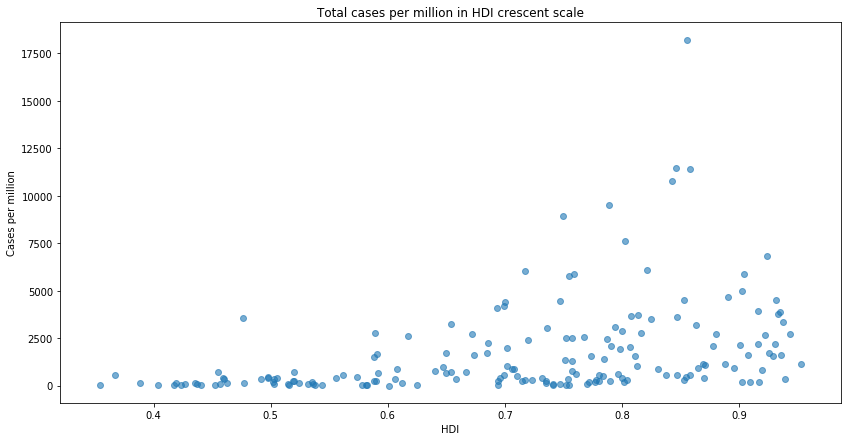

In [2]:
columns = ['continent', 'location', 'human_development_index', 'total_cases_per_million', 'total_deaths_per_million']
hdi_df = load_df(columns, continental=False).groupby(['location']).mean().dropna()

fig = plt.figure(figsize =(14, 7))
plt.scatter(hdi_df['human_development_index'], hdi_df['total_cases_per_million'], alpha=0.6)
plt.xlabel('HDI')
plt.ylabel('Cases per million')
plt.title("Total cases per million in HDI crescent scale")
plt.show()

Calculating pearson's correlation, we can confirm the values are somewhat correlated:

In [3]:
hdi_correlation = hdi_df.corr(method='pearson').values[0][1]

print('HDI correlation: '+str(hdi_correlation))

HDI correlation: 0.38685586538456895


To better understand how much of this correlation could be explained by chance, let's make a simulation: in the example below, we measure the mean of the total cases per million of inhabitants for the countries with HDI above 0.7. Then we shuffle the cases per million values to simulate an uniform distribution of data and again we measure the mean of the total cases per million of inhabitants for this new simulated data, we repeat that 1000 times. With that information, we can plot a normal distribution for the obtained means and see how that distribution compares to the real mean we first measured. This way, we can calculate how likely it would be to occasionally find in an uniformly distributed scenario (where the number of cases is not related to the country's HDI) a value more extreme than the one we have got in the real scenario.

In [4]:
high_hdi = hdi_df[hdi_df['human_development_index'] > 0.7]
high_hdi_mean = high_hdi['total_cases_per_million'].mean()

shuffle_df = hdi_df.copy()
n_samples = 1000
samples = np.zeros(n_samples)
for i in range(n_samples):
    np.random.shuffle(shuffle_df['human_development_index'])
    sample = shuffle_df[shuffle_df['human_development_index'] > 0.7]
    samples[i] = sample['total_cases_per_million'].mean()

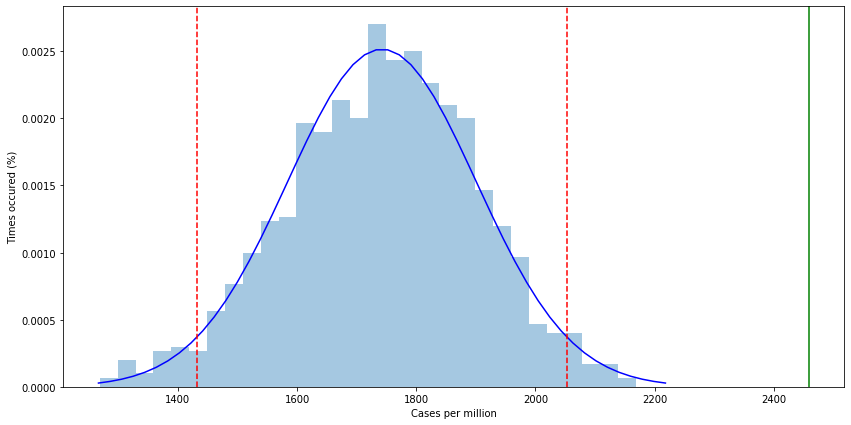

In [5]:
mu = samples.mean()
variance = samples.var()
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma)
ic = stats.norm.interval(0.95, loc=mu, scale=sigma)
norm = stats.norm.pdf(x, mu, sigma)

fig = plt.figure(figsize =(14, 7))
plt.hist(samples, bins=30, density=True, alpha=0.4)
plt.plot(x, norm, color='blue')
plt.axvline(high_hdi_mean, ymin=0, ymax=1, color='green')
plt.axvline(ic[0], ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(ic[1], ymin=0, ymax=1, color='red', linestyle='--')

plt.xlabel('Cases per million')
plt.ylabel('Times occured (%)')
plt.show()

In [6]:
print('Confidence interval:'+ str(ic))
print('Observed value: '+ str(high_hdi_mean))
upper_values = 1-stats.norm.cdf(high_hdi_mean, loc=mu, scale=sigma)
print('Chance of observing a value more extreme than the real measure: '+ str(upper_values))

Confidence interval:(1431.578336170762, 2053.2314045168723)
Observed value: 2458.519139514976
Chance of observing a value more extreme than the real measure: 3.157372326922925e-06


As we can see, the probability of observing a measure more extreme than the one we found (if there is no correlation between the data whatsoever) is lower than 5%, infact, it is very close to 0. This would suggest that is very unlikely that our observed value is explained by chance, therefore, it would be relevant to study which factors are involved in such correlation. But first, to illustrate how values are correlated, let's study a pair plot:

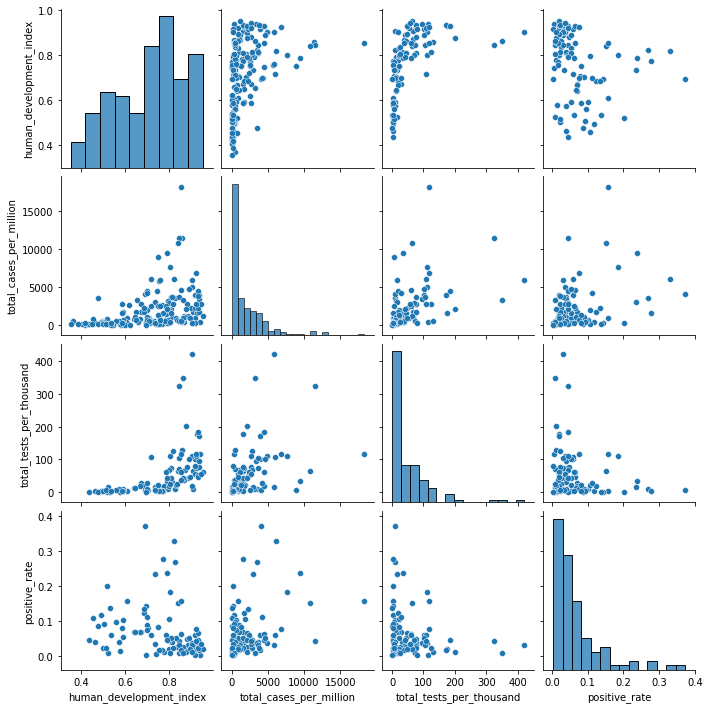

In [7]:
columns = ['continent', 'location', 'human_development_index', 'total_cases_per_million', 'total_tests_per_thousand', 'positive_rate']
data = load_df(columns, continental=False).groupby(by='location').mean()
sns.pairplot(data)
plt.show()

### HDI and under-notification

The image above suggests that although developed countries do have a higher number of cases, they also tend to realize more tests in general. However, the plot also suggests that developed countries have a lower positive rate in general, seen that the HDI x positive rate plot has a concentration of dots on its bottom right corner. This would imply in a false notion of number of cases, resulting on the illusion that developed countries have a higher number of cases per million. To reinforce this afirmation, lets see the following boxplot:

In [8]:
columns = ['continent', 'location', 'human_development_index', 'positive_rate']
tests_df = load_df(columns, continental=False).groupby(by='location').mean().dropna()

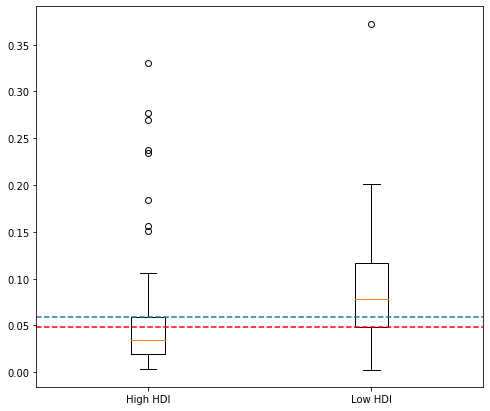

In [9]:
high_hdi = tests_df[tests_df['human_development_index'] >= 0.7]
low_hdi = tests_df[tests_df['human_development_index'] < 0.7]

fig = plt.figure(figsize =(8, 7))

plt.boxplot([high_hdi['positive_rate'], low_hdi['positive_rate']], labels=['High HDI', 'Low HDI'])
plt.axhline(np.percentile(high_hdi['positive_rate'], 75), linestyle='--')
plt.axhline(np.percentile(low_hdi['positive_rate'], 25), color='red', linestyle='--')
plt.show()

The box plot shows that although we do have some intersection between the cases on average, we can say it is quite small, therefore, this difference is likely affecting total cases per thousand for each country. If underdeveloped countries realized as many tests as developed countries, they would likely have a higher number of cases, this indicates that there is a problem of under-notification on these locations.

We can also observe the existing outliers among the countries with higher HDI, the reasons why such cases exists are unclear, but it is a matter for further study in the future. Those countries are listed below. 

In [10]:
outliers = high_hdi[high_hdi['positive_rate'] > 0.12]
outliers

,human_development_index,positive_rate
location,,
Argentina,0.825,0.269115
Chile,0.843,0.150424
Dominican Republic,0.736,0.234042
Kuwait,0.803,0.184037
Mexico,0.774,0.277225
Oman,0.821,0.330039
Panama,0.789,0.237934
Qatar,0.856,0.156365


We can confirm the hypotesis of developed countries having a lower positive rate with the same test as we did for the number of cases. The test is shown below, as expected, we have enough evidence to reject our null hypotesis "a country's HDI does not influence it's positve rate" and say it is very unlikely that the observed tendency happend by chance.

In [11]:
high_hdi_mean = high_hdi['positive_rate'].mean()

shuffle_tests = tests_df.copy()
n_samples = 1000
samples = np.zeros(n_samples)
for i in range(n_samples):
    np.random.shuffle(shuffle_tests['human_development_index'])
    sample = shuffle_tests[shuffle_tests['human_development_index'] > 0.7]
    samples[i] = sample['positive_rate'].mean()

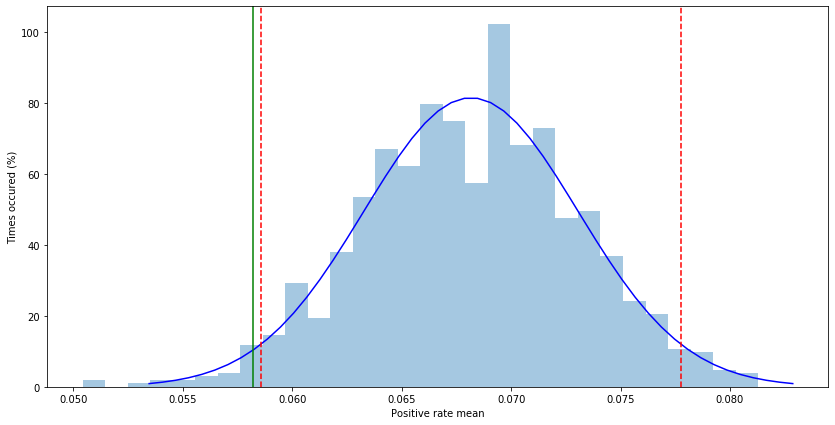

In [12]:
mu = samples.mean()
variance = samples.var()
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma)
ic = stats.norm.interval(0.95, loc=mu, scale=sigma)
norm = stats.norm.pdf(x, mu, sigma)

fig = plt.figure(figsize =(14, 7))
plt.hist(samples, bins=30, density=True, alpha=0.4)
plt.plot(x, norm, color='blue')
plt.axvline(high_hdi_mean, ymin=0, ymax=1, color='green')
plt.axvline(ic[0], ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(ic[1], ymin=0, ymax=1, color='red', linestyle='--')

plt.xlabel('Positive rate mean')
plt.ylabel('Times occured (%)')
plt.show()

### HDI and mortality

We have stabilished that although data suggests that developed countries tend to have more COVID cases, this may be due to under-notification on underdeveloped countries. If that is true, and furthermore, if developed countries have indeed less cases (when considering those unidentified) we can expect that those countries will have a lower mortality rate, due both to having more resources to treat the sick and their lowest number of cases. Lets see how these assumptions hold up.

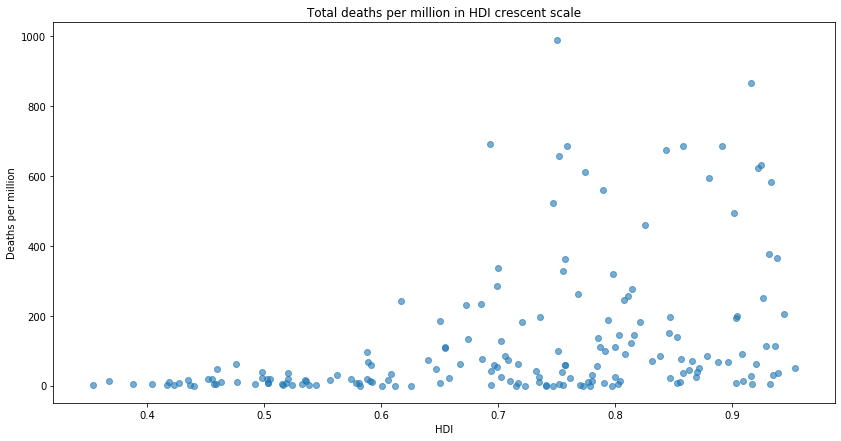

In [13]:
columns = ['continent', 'location', 'human_development_index', 'total_deaths_per_million']
hdi_df = load_df(columns, continental=False).dropna()
hdi_df = hdi_df.groupby(by='location').max()

fig = plt.figure(figsize =(14, 7))
plt.scatter(hdi_df['human_development_index'], hdi_df['total_deaths_per_million'], alpha=0.6)
plt.xlabel('HDI')
plt.ylabel('Deaths per million')
plt.title("Total deaths per million in HDI crescent scale")
plt.show()

Despite our expectations, a higher HDI does not seem to imply a lower death rate whatsoever, but this confusion could be much like the one we got from lokking at the total cases. One hypotesis could be that developed countries have a more elderly populations. To validate this, lets look at some data.

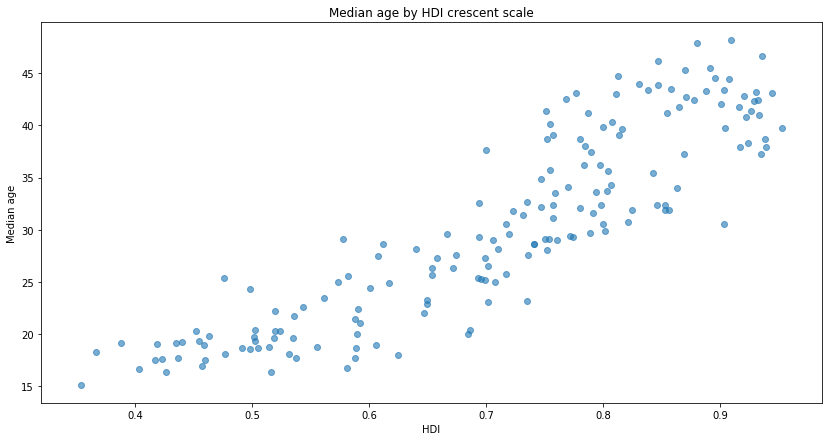

In [14]:
columns = ['continent', 'location', 'human_development_index', 'median_age', 'total_deaths_per_million']
hdi_df = load_df(columns, continental=False).dropna().groupby(by='location').max()

fig = plt.figure(figsize =(14, 7))
plt.scatter(hdi_df['human_development_index'], hdi_df['median_age'], alpha=0.6)
plt.xlabel('HDI')
plt.ylabel('Median age')
plt.title("Median age by HDI crescent scale")
plt.show()

The chart above seems in line with our hypotesis, however, to ensure we are not mislead, lets calculate Pearson's correlation.

In [15]:
hdi_correlation = hdi_df.corr(method='pearson')

print('HDI correlation:')
hdi_correlation

HDI correlation:


,human_development_index,median_age,total_deaths_per_million
human_development_index,1.000000,0.888098,0.385608
median_age,0.888098,1.000000,0.317956
total_deaths_per_million,0.385608,0.317956,1.000000


 As we can see, the data is indeed correlated, moreover, the total deaths per million is almost as correlated to HDI as it is to meddian age. To compare how that is impacting the number of deaths, we will try to present a polynomial regression that corroborates to our afirmative, and then compare the obtained tendency to another polynomial regression obtained by comparing HDI and number of deaths.

In [16]:
columns = ['total_deaths_per_million', 'human_development_index', 'median_age']
norm_hdi_df = hdi_df[columns]/hdi_df[columns].sum()

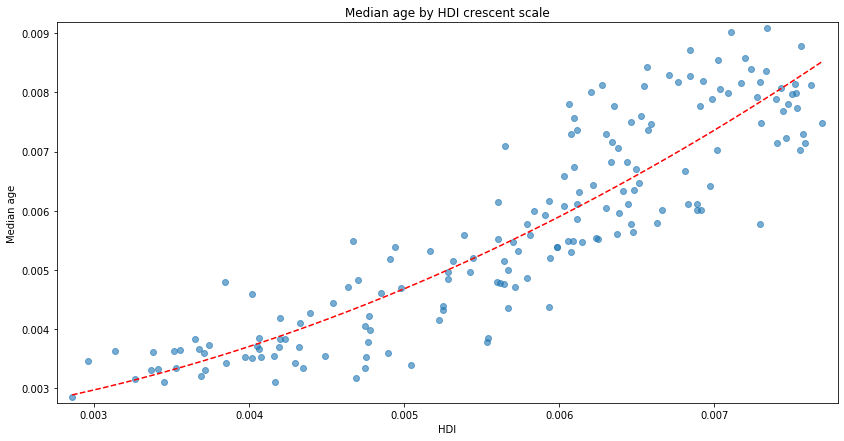

In [17]:
age_model = np.poly1d(np.polyfit(norm_hdi_df['human_development_index'], norm_hdi_df['median_age'], 2))

fig = plt.figure(figsize =(14, 7))
plt.scatter(norm_hdi_df['human_development_index'], norm_hdi_df['median_age'], alpha=0.6)
age_line = np.linspace(norm_hdi_df['human_development_index'].min(), norm_hdi_df['human_development_index'].max(), 100)
plt.plot(age_line, age_model(age_line), color='red', linestyle='--')
plt.xlabel('HDI')
plt.ylabel('Median age')
plt.title("Median age by HDI crescent scale")

plt.xlim(norm_hdi_df['human_development_index'].min()-0.0001, norm_hdi_df['human_development_index'].max()+0.0001)
plt.ylim(norm_hdi_df['median_age'].min()-0.0001, norm_hdi_df['median_age'].max()+0.0001)

plt.show()

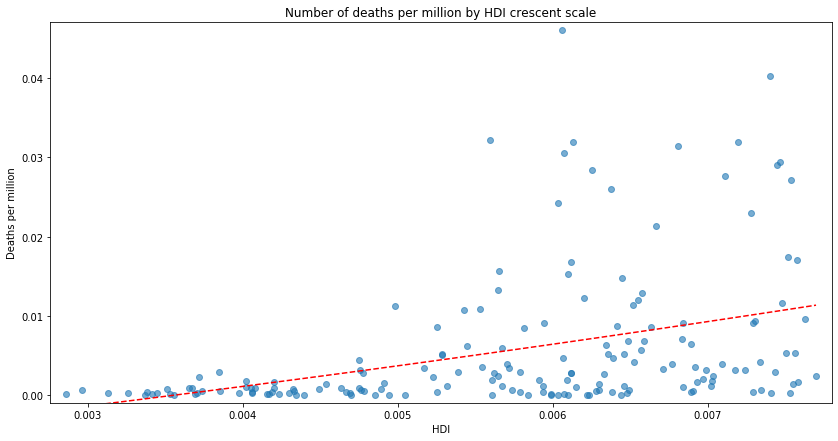

In [18]:
deaths_model = np.poly1d(np.polyfit(norm_hdi_df['human_development_index'], norm_hdi_df['total_deaths_per_million'], 2))

fig = plt.figure(figsize =(14, 7))
plt.scatter(norm_hdi_df['human_development_index'], norm_hdi_df['total_deaths_per_million'], alpha=0.6)
dedaths_line = np.linspace(norm_hdi_df['human_development_index'].min(), norm_hdi_df['human_development_index'].max(), 100)
plt.plot(dedaths_line, deaths_model(dedaths_line), color='red', linestyle='--')
plt.xlabel('HDI')
plt.ylabel('Deaths per million')
plt.title("Number of deaths per million by HDI crescent scale")

plt.xlim(norm_hdi_df['human_development_index'].min()-0.0001, norm_hdi_df['human_development_index'].max()+0.0001)
plt.ylim(norm_hdi_df['total_deaths_per_million'].min()-0.001, norm_hdi_df['total_deaths_per_million'].max()+0.001)

plt.show()

To help us visualize how the tendencies compare, lets remove the dots and plot the lines on the same plane.

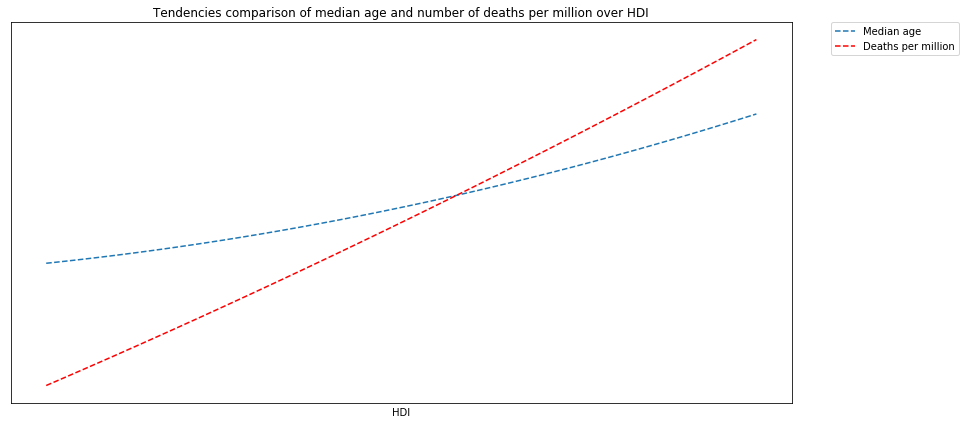

In [22]:
fig = plt.figure(figsize =(14, 7))
age_line_plt = plt.plot(age_line, age_model(age_line), linestyle='--', label='Median age')
dedaths_line_plt = plt.plot(dedaths_line, deaths_model(dedaths_line), color='red', linestyle='--', label='Deaths per million')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.xlabel('HDI')
plt.title("Tendencies comparison of median age and number of deaths per million over HDI")
plt.show()

All things considered, we can say that there is a fair chance that the incresed number of deaths on developed countries is related to the increased population median age, although it does not seem to be a one to one relation. This is expected, seen that a higher number patients in critical state results in less hospital beds, causing even those who are not 65 or older to not receive the adequate treatment.